In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pybedtools

In [6]:
'''
Created on May 3, 2016

@author: Gabe
'''
import pyBigWig
import numpy as np

class ReadDensity():
    """
    BigWig class
    Attributes:
        self.pos(positive *.bw file)
        self.neg(negative *.bw file)
    """
    def __init__(self, pos, neg, name = None):
        self.pos = pyBigWig.open(pos)
        self.neg = pyBigWig.open(neg)
        self.name = name if name is not None else pos.replace('pos','*').replace('neg','*')
        
    def get_name(self):
        """
        returns name
        """
        return self.name
    
    def values(self, chrom, start, end, strand):
        """
        Given a chromosome coordinate, return a list of values
        pertaining to the rbpmaps over each nucleotide position
        
        Args:
            chrom (str): (eg. chr1)
            start (int): 0-based start (first position in chromosome is 0)
            end (int): 1-based end (last position is not included)
            strand (char): either '+' or '-'
        """
        try:
            if strand == "+":
                return self.pos.values(chrom, start, end)
            elif strand == "-":
                return list(reversed(self.neg.values(chrom, start, end)))
            else:
                raise("Strand neither + or -")
        except RuntimeError:
            # usually occurs when no chromosome exists in the bigwig file
            return [np.NaN]*abs(start-end)
        

In [51]:
def three_prime_site(rbp,                   # type: ReadDensity
                     downstream_interval,   # type: BedTools.Interval
                     interval,              # type: BedTools.Interval
                     exon_offset,           # type: int
                     intron_offset,         # type: int
                     trunc = True):         # type: Boolean
    # [      ]-----|-----[   |   ]-----|----[   ]
    # type: (...) -> (int, list, int)
    '''
    Given an downstream exon and a focus exon, return a list of density 
    values of the surrounding 3' intron/exon boundary given 
    exon_offset and intron_offset parameters. Also returns the 
    list of padded values which can be appended to either end of
    the returned list in order to conform to a uniform length. 
    
    Args:
        rbp: ReadDensity object containing *.pos and *.neg bigwig files
        upstream interval: Interval describing an exon/feature upstream of
            the current feature.
        interval: The focus interval/exon.
        exon_offset: the number of nt from the 5' Exon boundary into the exon.
        intron_offset: the number of nt from the 5' Exon boundary into the intron.
        trunc: if trunc is True, then consider instances where 
            exon_offset > length of the exon.
    Returns: 
        left_pad: if the desired wiggle length is X but the returned wiggle 
            does not span the entire length, return N where N is the number
            of upstream positions that will need to be filled for len(wiggle)=X.
            E.G. exon_offset+intron_offset = 10.
                left_pad = 3: NNN1111111
        wiggle: list of densities given a region.
        right_pad: if the desired wiggle length is X but the returned wiggle 
            does not span the entire length, return N where N is the number
            of downstream positions that will need to be filled for len(wiggle)=X.
            E.G. exon_offset+intron_offset = 10.
                right_pad = 3: 1111111NNN
    '''
    exon = exon_offset
    intron = intron_offset
    
    left_pad = 0
    right_pad = 0
    
    if interval.strand == "+":
        if(trunc == True):
            if interval.end + intron_offset > downstream_interval.start:
                intron_offset = downstream_interval.start - interval.end
                right_pad = intron - intron_offset
            if interval.end - exon_offset < interval.start:
                exon_offset = interval.end - interval.start
                left_pad = exon - exon_offset
        wiggle = rbp.values(interval.chrom, interval.end - exon_offset, interval.end + intron_offset, interval.strand)
    elif interval.strand == "-":
        if(trunc == True):
            if interval.start + exon_offset > interval.end:
                exon_offset = interval.end - interval.start
                right_pad = exon - exon_offset
            if interval.start - intron_offset < downstream_interval.end:
                intron_offset = interval.start - downstream_interval.end
                left_pad = intron - intron_offset
        print("start:{},point:{},end:{}".format((interval.start - intron_offset),interval.start, (interval.start+exon_offset)))
        wiggle = rbp.values(interval.chrom, interval.start - intron_offset, interval.start + exon_offset, interval.strand)
    return left_pad, wiggle, right_pad

In [52]:
def five_prime_site(rbp,                # type: ReadDensity
                    upstream_interval,  # type: BedTools.Interval
                    interval,           # type: BedTools.Interval
                    exon_offset,        # type: int
                    intron_offset,      # type: int
                    trunc = True):      # type: boolean
    # type: (...) -> (int, list, int)
    '''
    Given an upstream exon and a focus exon, return a list of density 
    values of the surrounding 5' intron/exon boundary given 
    exon_offset and intron_offset parameters. Also returns the 
    list of padded values which can be appended to either end of
    the returned list in order to conform to a uniform length. 
    
    Args:
        rbp: ReadDensity object containing *.pos and *.neg bigwig files
        upstream interval: Interval describing an exon/feature upstream of
            the current feature.
        interval: The focus interval/exon.
        exon_offset: the number of nt from the 5' Exon boundary into the exon.
        intron_offset: the number of nt from the 5' Exon boundary into the intron.
        trunc: if trunc is True, then consider instances where 
            exon_offset > length of the exon.
    Returns: 
        left_pad: if the desired wiggle length is X but the returned wiggle 
            does not span the entire length, return N where N is the number
            of upstream positions that will need to be filled for len(wiggle)=X.
            E.G. exon_offset+intron_offset = 10.
                left_pad = 3: NNN1111111
        wiggle: list of densities given a region.
        right_pad: if the desired wiggle length is X but the returned wiggle 
            does not span the entire length, return N where N is the number
            of downstream positions that will need to be filled for len(wiggle)=X.
            E.G. exon_offset+intron_offset = 10.
                right_pad = 3: 1111111NNN
    '''
    exon = exon_offset
    intron = intron_offset
    
    left_pad = 0
    right_pad = 0
    # [    ]-----|-----[2  |  |  8]-----|----[10   15]
    if interval.strand == "+":
        if(trunc == True):
            if interval.start + exon_offset > interval.end:
                exon_offset = interval.end - interval.start
                right_pad = exon - exon_offset
            if interval.end - intron_offset < upstream_interval.end:
                intron_offset = interval.start - upstream_interval.end
                left_pad = intron - intron_offset
        wiggle = rbp.values(interval.chrom, (interval.start - intron_offset), (interval.start + exon_offset), interval.strand)
    elif interval.strand == "-":
        if(trunc == True):
            if interval.end - exon_offset < interval.start:
                exon_offset = interval.end - interval.start
                left_pad = exon - exon_offset
            if interval.end + intron_offset > upstream_interval.start:
                intron_offset = upstream_interval.start - interval.end
                right_pad = intron - intron_offset
        wiggle = rbp.values(interval.chrom, (interval.end - exon_offset), (interval.end + intron_offset), interval.strand)
    return left_pad, wiggle, right_pad

In [53]:
pos = '/projects/ps-yeolab3/encode/analysis/encode_v12/227_01_SLTM.merged.r2.norm.neg.bw'
neg = '/projects/ps-yeolab3/encode/analysis/encode_v12/227_01_SLTM.merged.r2.norm.pos.bw'

In [54]:
sltm = ReadDensity(pos=pos,neg=neg)

In [60]:
### Original interval ###
# chr10:100186972:100187021:-@chr10:100185575:100185742:-@chr10:100185298:100185477:-     ENSG00000107521
upstream_interval = pybedtools.BedTool('chr10 100186972 100187021 0 0 -', from_string=True)[0]
interval = pybedtools.BedTool('chr10 100185575 100185742 0 0 -', from_string=True)[0]
downstream_interval = pybedtools.BedTool('chr10 100185298 100185477 0 -', from_string=True)[0]

# [   |__]___|----[     ]--------[    ]

In [77]:
# test left and right pad (should be 1)
upstream_interval = pybedtools.BedTool('chr10 100187000 100187049 0 0 -', from_string=True)[0] # 
interval = pybedtools.BedTool('chr10 100186000 100186501 0 0 -', from_string=True)[0] # 100185742 to 100186623
downstream_interval = pybedtools.BedTool('chr10 100185000 100185100 0 -', from_string=True)[0]

rbp = sltm
exon_offset = 50
intron_offset = 500
left_pad, wiggle, right_pad = three_prime_site(rbp,                   # type: ReadDensity
                                               interval,              # type: BedTools.Interval
                                               upstream_interval,   # type: BedTools.Interval
                                               exon_offset,           # type: int
                                               intron_offset,         # type: int
                                               trunc = True)  
print("left pad: {}, right_pad: {}".format(left_pad,right_pad))

start:100186501,point:100187000,end:100187049
left pad: 1, right_pad: 1


In [78]:
# test left and right pad (should be 1)
upstream_interval = pybedtools.BedTool('chr10 100187000 100187051 0 0 -', from_string=True)[0] # 
interval = pybedtools.BedTool('chr10 100186000 100186499 0 0 -', from_string=True)[0] # 100185742 to 100186623
downstream_interval = pybedtools.BedTool('chr10 100185000 100185100 0 -', from_string=True)[0]

rbp = sltm
exon_offset = 50
intron_offset = 500
left_pad, wiggle, right_pad = three_prime_site(rbp,                   # type: ReadDensity
                                               interval,              # type: BedTools.Interval
                                               upstream_interval,   # type: BedTools.Interval
                                               exon_offset,           # type: int
                                               intron_offset,         # type: int
                                               trunc = True)  
print("left pad: {}, right_pad: {}".format(left_pad,right_pad))

start:100186500,point:100187000,end:100187050
left pad: 0, right_pad: 0


left pad: 0, right_pad: 0


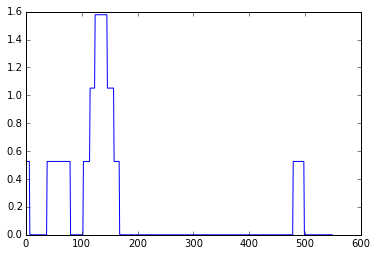

In [91]:
# test left and right pad (should be 0)
upstream_interval = pybedtools.BedTool('chr10 98634500 98635500 0 0 +', from_string=True)[0] # 
interval = pybedtools.BedTool('chr10 98636500 98637500 0 0 +', from_string=True)[0] # 100185742 to 100186623
downstream_interval = pybedtools.BedTool('chr10 98638500 98639500 0 +', from_string=True)[0]

rbp = sltm
exon_offset = 50
intron_offset = 500
left_pad, wiggle, right_pad = three_prime_site(rbp,                   # type: ReadDensity
                                               interval,              # type: BedTools.Interval
                                               upstream_interval,   # type: BedTools.Interval
                                               exon_offset,           # type: int
                                               intron_offset,         # type: int
                                               trunc = True)  
print("left pad: {}, right_pad: {}".format(left_pad,right_pad))
plt.plot(abs(pd.Series(wiggle).fillna(0)))

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 -0.5258334279060364,
 nan,
 nan,
 nan,
